In [11]:
import pandas as pd
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords

## Quais são os produtos mais catalogados?
## Quais produtos tem mais unidades vendidas?
## Qual o preço médio dos produtos?
## Qual material é mais vendido? Qual é menos vendido?
## O valor do desconto tem relação com o número de vendas?


In [12]:
def plota_variaveis_numericas(dataframe: pd.DataFrame, conjunto: list, alvo: str, titulo: str, modo='barra', tamanho_figura = (15,30), i=0) -> None:
    nrows = int(round(len(conjunto)/2, 0))
    
    if nrows < (len(conjunto)/2):
        nrows += 1

    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=tamanho_figura, facecolor='white')
    axes = axes.flatten()
    fig.suptitle(titulo)
    #fig.subplots_adjust(hspace=0.8, wspace=0.3)


    for item in conjunto:
        if modo == 'barra':
            sns.barplot(x=dataframe[alvo], y=dataframe[item], ax=axes[i], color='#435058')
            axes[i].set_title(item)

        elif modo=='histograma':
            sns.histplot(x=dataframe[item], ax=axes[i], color='#435058')
            axes[i].axvline(x=dataframe[item].mean(), linestyle='--', color='red')
            axes[i].axvline(x=dataframe[item].median(), linestyle='--', color='green')
            axes[i].set_title(item + '. Média = {:.2f}, Mediana = {:.2f}'.format(dataframe[item].mean(), dataframe[item].median()))

        if dataframe[item].nunique() > 6:
            axes[i].xaxis.set_tick_params(rotation=90)

        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
        i += 1
   
    fig.tight_layout(pad=2)

def plota_contagens(dataframe: pd.DataFrame, conjunto: list, alvo: str, titulo: str, tamanho_figura = (15,22), i=0) -> None:
    nrows = int(round(len(conjunto)/2, 0))

    if nrows < (len(conjunto)/2):
        nrows += 1

    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=tamanho_figura, facecolor='white')
    axes = axes.flatten()
    fig.suptitle(titulo)

    for item in conjunto:
        sns.countplot(x=dataframe[item], ax=axes[i], palette='Paired', hue=dataframe[alvo])
        axes[i].set_title(item)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
        i += 1
        
    fig.tight_layout(pad=2)


def plota_dispersao(dataframe: pd.DataFrame, conjunto: list, var: str, titulo: str, legenda=None, tamanho_figura = (20,12), i=0) -> None:
    nrows = int(round(len(conjunto)/2, 0))

    if nrows < (len(conjunto)/2):
        nrows += 1

    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=tamanho_figura, facecolor='white')
    axes = axes.flatten()
    fig.suptitle(titulo)


    for item in conjunto:
        if legenda is not None:
            sns.scatterplot(x=dataframe[var], y=dataframe[item], ax=axes[i], hue=dataframe[legenda])
        else:
            sns.scatterplot(x=dataframe[var], y=dataframe[item], ax=axes[i])

        i += 1
    fig.tight_layout(pad=2)

In [2]:
df = pd.read_csv('dataset_roupas_marketplacebr_limpo.csv')

In [3]:
df.head()
df = df.drop_duplicates()
df = df.drop(['Unnamed: 0'], axis=1)

In [4]:
textos = ' '.join(df['Título'])
palavras = textos.lower().split()
palavras = [palavra for palavra in palavras if palavra not in stopwords.words('portuguese')]
palavras = [palavra for palavra in palavras if len(palavra) > 3]

In [5]:
word_count = Counter(palavras)

print(word_count.most_common(100))

[('roupa', 583), ('infantil', 402), ('calça', 396), ('jeans', 333), ('short', 271), ('feminina', 250), ('masculina', 247), ('conjunto', 231), ('feminino', 223), ('bermuda', 207), ('roupas', 190), ('alta', 189), ('cintura', 187), ('plus', 165), ('size', 163), ('bebê', 154), ('shorts', 152), ('lycra', 149), ('academia', 142), ('algodão', 135), ('cuecas', 125), ('masculino', 124), ('atacado', 122), ('menino', 116), ('boxer', 105), ('menina', 105), ('peças', 102), ('lupo', 92), ('ballet', 88), ('body', 82), ('saia', 81), ('moda', 81), ('fitness', 80), ('bumbum', 76), ('original', 67), ('moletom', 67), ('blusa', 66), ('praia', 62), ('tactel', 61), ('costura', 59), ('térmica', 59), ('verão', 59), ('juvenil', 57), ('bermudas', 53), ('premium', 52), ('manga', 52), ('adulto', 52), ('uniforme', 50), ('estampado', 50), ('proteção', 50), ('femininas', 50), ('elastano', 49), ('bebe', 49), ('jogger', 48), ('levanta', 48), ('segunda', 44), ('pele', 44), ('macacão', 44), ('apicultor', 43), ('azul', 42

In [6]:
pecas = ['calça', 'short', 'conjunto', 'bermuda', 'shorts', 'cuecas', 'ballet', 'body', 'saia', 'blusa', 'bermudas', 'uniforme', 'macacão',
         'cueca', 'camiseta', 'meia', 'calças', 'conjuntos', 'mala', 'cinto', 'pijama', 'camisa', 'boné']

In [7]:
def tipifica_roupa(linha):
    for item in pecas:
        if item in linha:
            return item
    
    return 'outros'

In [8]:
df['Título'] = df['Título'].apply(lambda x: x.lower())
df['tipo_roupa'] = df['Título'].apply(tipifica_roupa)

<AxesSubplot: title={'center': 'Tipos de produtos vendidos'}, xlabel='tipo_roupa'>

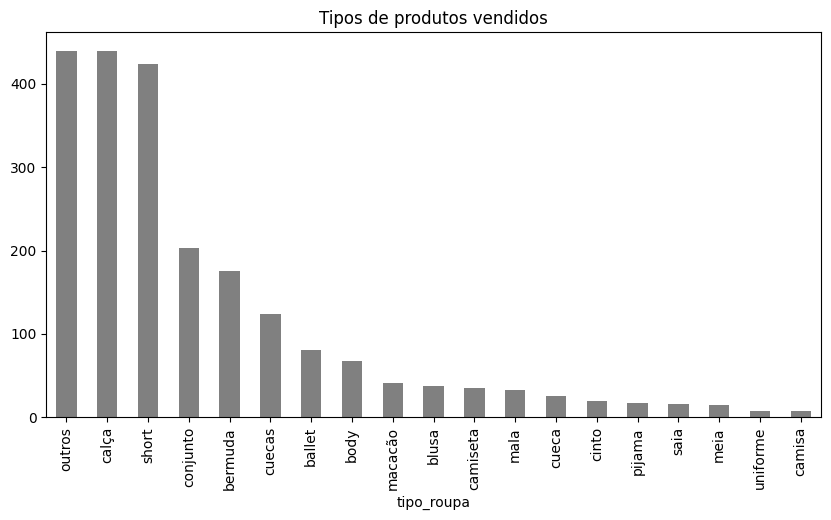

In [9]:
df['tipo_roupa'].value_counts().plot(kind='bar', color='gray', figsize=(10, 5), title='Tipos de produtos vendidos')